In [1]:
%pip install emcee
%pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 3.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
from importlib import reload
import tqdm
import time
import emcee
from google.colab import files
from copy import deepcopy

In [6]:
def pi_R(x): # propotional density of Rosenbrock function
  a = (100*((x[1] - x[0]**2)**2) + (1-x[0])**2)/20
  return np.exp(-a/20)

def Hessian(x): # Hessian
  H = np.zeros((2,2))
  H[0,0] = 20*x[1] + 60*(x[0]**2) + 1/10 
  H[1,0] = 20*x[0]
  H[0,1] = 20*x[0]
  H[1,1] = -10
  return H

def sqrt_R(x): # positive square-root of inverse Hessian
  H = Hessian(x) # Hessian
  S = np.linalg.inv(H) # inverse Hessian
  det_S = np.linalg.det(S) # determinant of S
  R = (S+np.sqrt(np.abs(det_S))*np.eye(2))/np.sqrt(np.abs(np.trace(S) + 2*np.sqrt(np.abs(det_S)))) # absolute value for S not positive-definite
  return R

def grad_V(x): # V = -log pi
  grad = np.zeros((2))
  grad[0] = -20*(x[1]-x[0]**2)*x[0] + (x[0]-1)/10 
  grad[1] = 10*(x[1] - x[0]**2)
  return grad

def Sto_Newton(h, max_itr = 10**6):
  lst = []
  x = np.random.rand(2)
  for st in range(max_itr):
    R = sqrt_R(x)
    S = R@R
    DVx = grad_V(x)
    y = x -h*S@DVx + np.sqrt(2*h)*R@np.random.normal(size=2)
    DVy = grad_V(y)
    q_yx = np.exp(-(y-x+h*S@DVx)@np.linalg.inv(S)@(y-x+h*S@DVx)/(4*h))
    q_xy = np.exp(-(x-y+h*S@DVy)@np.linalg.inv(S)@(x-y+h*S@DVy)/(4*h))
    p_acc = min(1, q_xy*pi_R(y)/(q_yx*pi_R(x)))
    if np.random.random() < p_acc: # Metropolize
      x = y
    lst.append(x[0])
  return lst

def OD_Langevin_M(h, max_itr = 10**6):
  lst = []
  x = np.random.rand(2)
  for st in range(max_itr):
    DVx = grad_V(x)
    y = x -h*DVx + np.sqrt(2*h)*np.random.normal(size=2)
    DVy = grad_V(y)
    q_yx = np.exp(-(y-x+h*DVx)@(y-x+h*DVx)/(4*h))
    q_xy = np.exp(-(x-y+h*DVy)@(x-y+h*DVy)/(4*h))
    p_acc = min(1, q_xy*pi_R(y)/(q_yx*pi_R(x))) 
    if np.random.random() < p_acc: # Metropolize
      x = y
    lst.append(x[0])
  return lst

In [8]:
h = 10**(-2)
his1 = Sto_Newton(h)
IAT1 = emcee.autocorr.integrated_time(his1, quiet=True)
print(IAT1)

N/50 = 20000;
tau: [56088.14836733]


[56088.14836733]


In [17]:
h = 10**(-2)
his1 = Sto_Newton(h)
IAT1 = emcee.autocorr.integrated_time(his1, quiet=True)
print(IAT1)

N/50 = 20000;
tau: [95794.08099281]


[95794.08099281]


In [18]:
h = 10**(-2)
his1 = Sto_Newton(h)
IAT1 = emcee.autocorr.integrated_time(his1, quiet=True)
print(IAT1)

[3364.16478186]


In [32]:
h = 10**(-2)
his1 = Sto_Newton(h)
IAT1 = emcee.autocorr.integrated_time(his1, quiet=True)
print(IAT1)

[10580.25259484]


In [34]:
h = 10**(-2)
his1 = Sto_Newton(h)
IAT1 = emcee.autocorr.integrated_time(his1, quiet=True)
print(IAT1)

[13966.70877991]


In [9]:
his2 = OD_Langevin_M(h)
IAT2 = emcee.autocorr.integrated_time(his2, quiet=True)
print(IAT2)

N/50 = 20000;
tau: [38103.59897241]


[38103.59897241]


In [16]:
his2 = OD_Langevin_M(h)
IAT2 = emcee.autocorr.integrated_time(his2, quiet=True)
print(IAT2)

N/50 = 20000;
tau: [60928.39850744]


[60928.39850744]


In [33]:
his2 = OD_Langevin_M(h)
IAT2 = emcee.autocorr.integrated_time(his2, quiet=True)
print(IAT2)

[10238.78486497]


In [19]:
his2 = OD_Langevin_M(h)
IAT2 = emcee.autocorr.integrated_time(his2, quiet=True)
print(IAT2)

N/50 = 20000;
tau: [109908.43178252]


[109908.43178252]


In [38]:
his2 = OD_Langevin_M(h)
IAT2 = emcee.autocorr.integrated_time(his2, quiet=True)
print(IAT2)

N/50 = 20000;
tau: [22613.8417611]


[22613.8417611]


In [20]:
def get_z(a):
  # generate z from [1/a, a]
  u = np.random.uniform()
  z = u*(2*np.sqrt(a)-2/np.sqrt(a))+2/np.sqrt(a)
  return (z/2)**2

def affine_invariant_ensemble(L, alpha):
  ensem = np.random.rand(2,L)
  lst = [] # valuate x_bar
  max_itr = 10**5
  for _ in range(max_itr):
    for i in range(L):
      j = np.random.randint(0, L)
      xi = ensem[:,i]
      xj = ensem[:,j]
      u = np.random.uniform()
      z = u*(2*np.sqrt(alpha)-2/np.sqrt(alpha))+2/np.sqrt(alpha)
      z = (z/2)**2
      y = z*xi + (1-z)*xj
      if np.random.random() < min(1,z*pi_R(y)/pi_R(xi)): # metropolize
        ensem[:,i] = y
      lst.append(np.mean(ensem[0,:]))
  return lst # max_itr by L matrix

In [39]:
L_list = [i for i in range(3, 11)]
alpha = np.sqrt(2)
IAT3 = []

for L in tqdm.tqdm(L_list):
  his3 = affine_invariant_ensemble(L, alpha)
  IAT3.append(emcee.autocorr.integrated_time(his3, quiet=True))

  0%|          | 0/8 [00:00<?, ?it/s]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 6000;
tau: [29369.56215644]
 12%|█▎        | 1/8 [00:17<02:04, 17.85s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8000;
tau: [50661.24548097]
 25%|██▌       | 2/8 [00:40<02:03, 20.64s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10000;
tau: [24970.32172833]
 38%|███▊      | 3/8 [01:08<01:59, 23.99s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 12000;
tau: [72722.2776023]
 50%|█████ 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

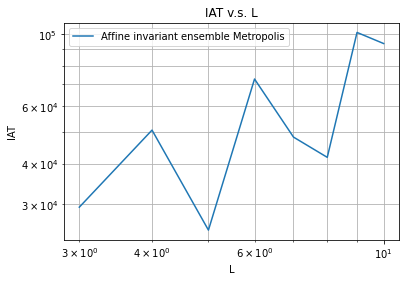

In [40]:
# IAT v.s. L
plt.plot(L_list, IAT3, label = "Affine invariant ensemble Metropolis")
plt.xscale('log')
plt.yscale('log')
plt.title('IAT v.s. L')
plt.xlabel('L')
plt.ylabel('IAT')
plt.grid(visible=True, which='both', axis='both')
plt.legend()
plt.savefig("75L.png")
files.download("75L.png")
plt.show()

In [41]:
L_list = [i for i in range(3, 11)]
alpha = np.sqrt(2)
IAT3 = []

for L in tqdm.tqdm(L_list):
  his3 = affine_invariant_ensemble(L, alpha)
  IAT3.append(emcee.autocorr.integrated_time(his3, quiet=True))

  0%|          | 0/8 [00:00<?, ?it/s]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 6000;
tau: [34078.42052521]
 12%|█▎        | 1/8 [00:17<02:02, 17.54s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8000;
tau: [48296.55095803]
 25%|██▌       | 2/8 [00:41<02:06, 21.13s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10000;
tau: [55497.43923206]
 38%|███▊      | 3/8 [01:09<02:02, 24.58s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 12000;
tau: [70044.37625592]
 50%|█████

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

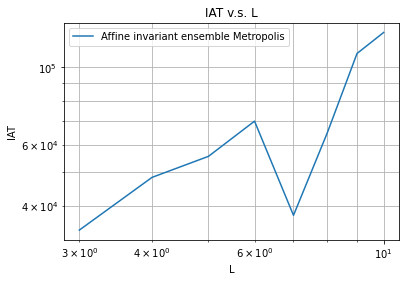

In [42]:
# IAT v.s. L
plt.plot(L_list, IAT3, label = "Affine invariant ensemble Metropolis")
plt.xscale('log')
plt.yscale('log')
plt.title('IAT v.s. L')
plt.xlabel('L')
plt.ylabel('IAT')
plt.grid(visible=True, which='both', axis='both')
plt.legend()
plt.savefig("75L.png")
files.download("75L.png")
plt.show()

In [29]:
alpha_list = [i for i in range(2, 11)]
L = 5
IAT4 = []

for alpha in tqdm.tqdm(alpha_list):
  his4 = affine_invariant_ensemble(L, alpha)
  IAT4.append(emcee.autocorr.integrated_time(his4, quiet=True))

  0%|          | 0/9 [00:00<?, ?it/s]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10000;
tau: [57239.9178779]
 11%|█         | 1/9 [00:28<03:51, 29.00s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10000;
tau: [46021.11639926]
 22%|██▏       | 2/9 [00:55<03:13, 27.60s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10000;
tau: [63211.19486856]
 33%|███▎      | 3/9 [01:22<02:42, 27.16s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10000;
tau: [27443.2725636]
 44%|████▍

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

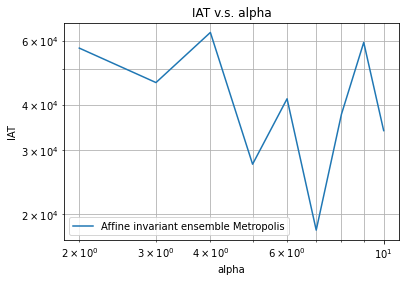

In [31]:
# IAT v.s. alpha
plt.plot(alpha_list, IAT4, label = "Affine invariant ensemble Metropolis")
plt.xscale('log')
plt.yscale('log')
plt.title('IAT v.s. alpha')
plt.xlabel('alpha')
plt.ylabel('IAT')
plt.grid(visible=True, which='both', axis='both')
plt.legend()
plt.savefig("75a.png")
files.download("75a.png")
plt.show()